# Challenge Kaggle : Partie 2
### Schwartz Antoine <br> Fournier Amaury


### Imports + Enregistrement du path CSV

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
%matplotlib inline

#path = "/media/3000708/ESD-USB/Kaggle/"
#path = "/Vrac/LMOR/"
#path = "C:/Users/S4rge09/Documents/Python Scripts/"
path  = "C:/Users/afournier/Desktop/kaggle/"

### Chargement des dataFrames de la partie 1

In [ ]:
# DFTRAIN :
# -- Full :
dftrain = pd.read_csv(path + "dftrain.csv")
# -- Sample :
#n = 1180945 # number of records in file
#s = n/100 # desired sample size
#lines2skip = sorted(np.arange(1, random.randint(1,n-s)))
#dftrain = pd.read_csv(path + "dftrain.csv", skiprows=lines2skip, nrows = s)

# DFTEST :
dftest = pd.read_csv(path + "dftest.csv")

# DFTRAIN_TEST :
# -- Notre sample :
#dftrain_test = pd.read_csv(path + "dftrain_test.csv")
# -- dftrain_test = dftrain 
dftrain_test = dftrain.copy()


# Marshall Palmer
# -- du test 
dfsample = pd.read_csv(path + "sample_solution.csv")

# -- du train_test (avec notre sample) :
#dfmtrain_test = pd.read_csv(path + "marshall_palmer_train_test.csv")
# -- du train (avec = dftrain)
dfmtrain = pd.read_csv(path + "marshall_palmer_train.csv")


# 1 - Phase de prétraitements

## Sélection de features manuelle (optionnelle)
Certains modèles gèrent plus ou moins bien la séléction des features qui leurs sont utiles. <br>
Lors de nos campagnes d'expériences, portées majoritèrement sur des modèles à base d'arbres, on a pu observé que "prémacher" la selection features pouvait faire gagner un peu en performance. Ceci étant expliqué par le bruit que peuvent provoquer certaines features inutiles lors de l'apprentissage d'arbres aléatoires.

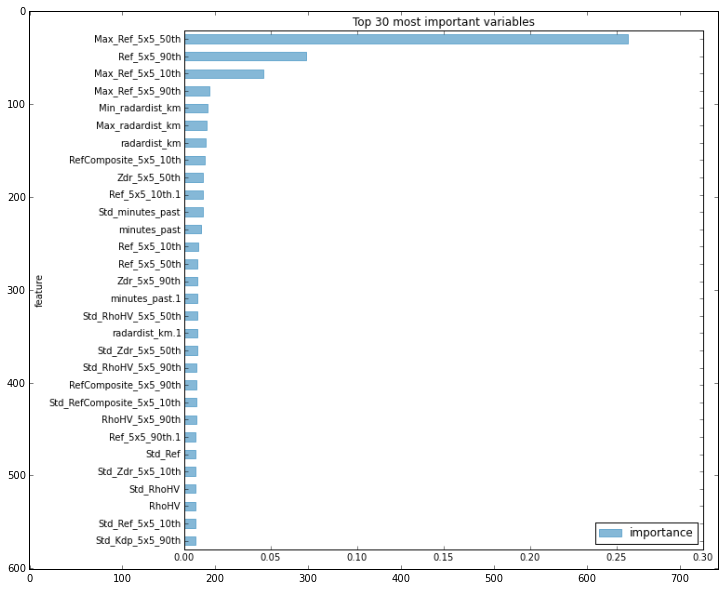

In [37]:
img=mpimg.imread(path + "k_images/exp30_alldata_rf100_dropna_top30.png")
pylab.rcParams['figure.figsize'] = (150, 10)
plt.imshow(img)

On peut voir ci-dessus les 30 features les plus importantes pour notre meilleur random forest.<br>
#### Aprés plusieurs tests sur la sélection de feature on a choisit de garder les 20 meilleures features pour nos modeles random forest.

In [ ]:
# --- Selection de features

# liste des features de base à garder 
liste = ['Ref_5x5_90th', 'radardist_km',  'RefComposite_5x5_10th',
              'Zdr_5x5_50th','minutes_past','Zdr_5x5_90th','Ref_5x5_10th',
              'Ref_5x5_50th', 'Max_Ref_5x5_50th','Max_radardist_km',
              'Max_Ref_5x5_90th','Max_Ref_5x5_10th', 'Min_radardist_km', 
              'Std_minutes_past', 'Std_RhoHV_5x5_50th', 'Std_RhoHV_5x5_90th',
              'Std_Zdr_5x5_50th']


# application de la selection features 

dftrain = dftrain[liste]
dftest = dftest[liste[1:]]
dftrain_test = dftrain_test[liste]

## Log1p
Appliquer la formule du log1p (log(1 + 'Expected')) permet de lisser la distribution des valeurs d'Expected et peut dans certains cas légerement améliorer les performances.

In [ ]:
# --- Apprendre sur Log1p(Expected) plutot que Expected
dftrain["Expected"] = np.log1p(dftrain["Expected"])

## Gérer les outliers selon Expected

Pour déterminer à partir de quelle valeur un Expected peut être considéré comme un outlier regardons la distribution des données selon le niveau de la jauge de pluie enregistré en une heure.

- Nous supprimons tout d'abord les données ayant une valeur d'Expected abérante c'est a dire celles dépassent le reccord mondial de pluie tombée en 1h 
reccord actuel : Holt, Missouri, États-Unis le 22 juin 1947, 305mm en 42 minutes.

On élimine avec cette opération 6.5% des données.

- Intérréssons nous maintenant à la distribution des exemples ayant un Expected < 300 :

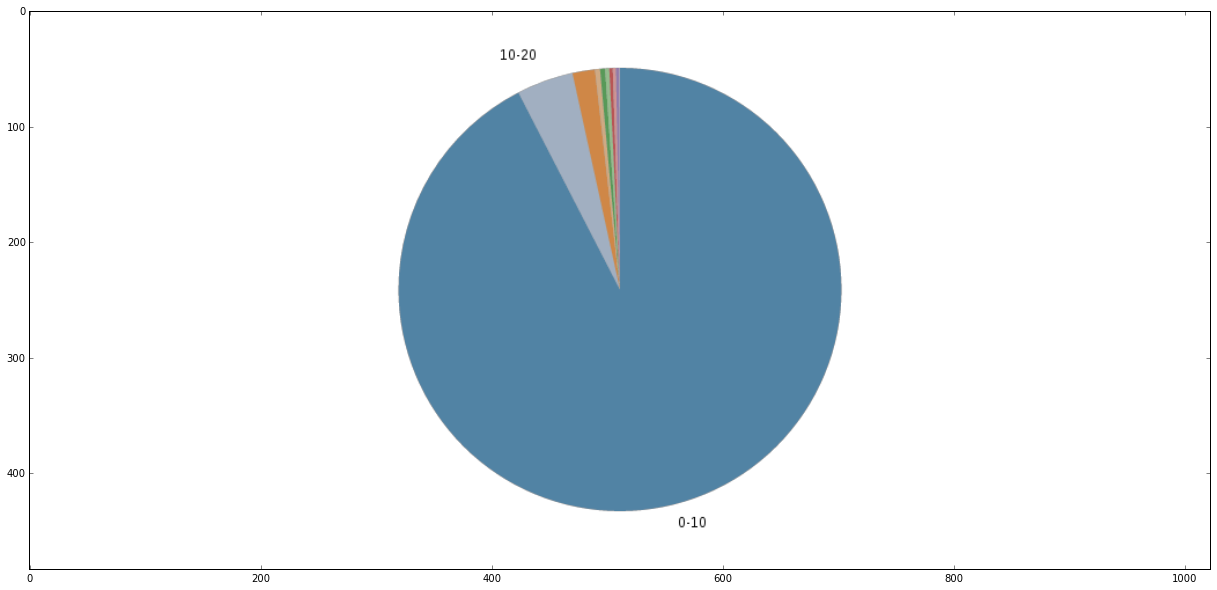

In [46]:
img=mpimg.imread(path + "Expected_100_10par10.png")
pylab.rcParams['figure.figsize'] = (50, 10)
plt.imshow(img)

Sur ce diagramme on découpe les Expected en tranche de 10.<br>
On peut clairement voir que la quasi-totalité des données ont un expected < 100.

Regardons plus en détail.

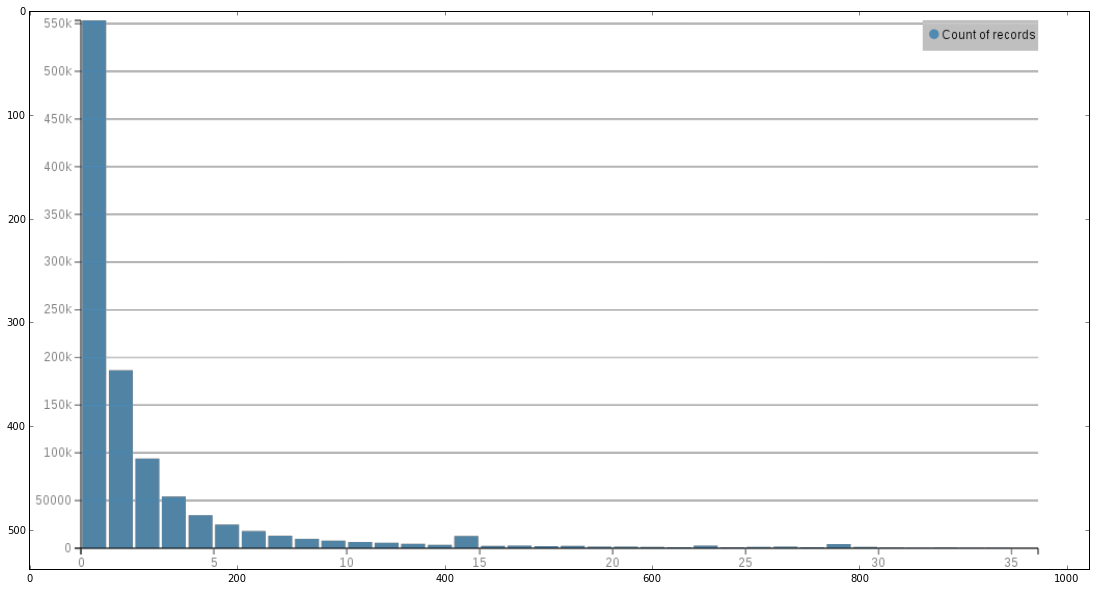

In [47]:
img=mpimg.imread(path + "Expected_40_1par1Diagramme.png")
pylab.rcParams['figure.figsize'] = (50, 10)
plt.imshow(img)

L'analyse de ce diagramme montre que la grande majorité des valeurs sont compris entre 0 et 5. Le choix de la coupure pour les outliers est un choix et dépend également du modèle utilisé. <br>
Nos résultats montreront par la suite que couper les expected supérieurs à 30 semble le plus optimal à nos modèles. <br>
Après cette opération, il nous reste 89.5% des données du dataset pour l'apprentissage.

In [ ]:
# --- Gérer les outliers
dftrain= dftrain.drop(dftrain[dftrain.Expected >= 30].index)
#dftrain = dftrain.drop(dftrain[dftrain.Expected > 15].index)
#dftrain = dftrain.drop(dftrain[dftrain.Expected > 100].index)
#dftrain = dftrain.drop(dftrain[dftrain.Expected > 25].index)


## Gérer les valeurs manquantes

Pour cette section nous nous sommes basés uniquement sur des méthodes relativement naïves. En effet nous nous sommes donné 2 options : 
- Supprimer totalement les lignes contenant des valeurs manquantes pour l'apprentissage, et remplir ces valeurs par moyenne en colonne pour le test
- Remplir les valeurs manquantes par une valeur extrème (-9999) en train et en test.

Cette dernière option étant pertinente uniquement pour des modèles à base d'arbres de décision (connus pour selectionner eux même les valeurs utiles à leur prédiction).

In [ ]:
# ---- Gérer les NaN

# - Pour Train
dftrain = dftrain.dropna()
#dftrain = dftrain.fillna(-9999)

# - Pour Test et Train_Test
dftest = dftest.fillna(dftest.mean())
dftrain_test = dftrain_test.fillna(dftrain.mean())
#dftest = dftest.fillna(-9999)
#dftrain_test = dftrain_test.fillna(-9999)
#dftest = dftest.fillna(dftest.median())


L'administrateur du challenge a précisé que si pour un même ID, toutes les valeurs de la colonne Ref étaient des NaN, alors l'ID ne serait pas considéré lors du scoring. <br>
Nous n'avons pas utilisé cette astuce pour l'apprentissage (car ça ne changeait pas grand chose), mais ça reste une piste exploitable.

In [ ]:
# ---- Drop_Ref_ALL_NULL
#ref_sums_train = dftrain['Ref'].groupby(level = 'Id').sum()
#null_refs_idx_train = [i for i in ref_sums_train.index if np.isnan(ref_sums_train[i])]
#dftrain.drop(null_refs_idx_train, axis = 0, inplace = True)

# 2 - Apprentissage

Pour ce challenge, nous sommes face à un problème de régression où le but est d'estimer la valeur d'Exepected.

Compte tenus des modèles utilisés par les gagnants du challenge How much did it rain I, nous avons fait le choix de baser notre apprentissage sur des modèles ensemblistes à base d'arbres de décisions : Random forest, Exetremly randomize trees et Gradient boosting. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error

X = dftrain.copy()
X.drop("Expected", axis=1, inplace=True)
# normalize éventuel pour SGDregressor
# X = normalize(X, norm='l2', axis=1, copy=True)
Y = dftrain["Expected"]

## Un GridSearch pour optimiser les modèles


In [ ]:
##import warnings
#warnings.filterwarnings('ignore')#

# -- SGDr
##tuned_parameters = {'loss': ['huber','squared_loss'], 
##                    'penalty':['l1', 'l2'],
##                    'alpha':[1e-1, 1e-2,1e-3, 1e-4, 1e-6, 1e-7, 1e-8], 
##                    'n_iter':[300] }
##model = SGDRegressor()

# - RF
tuned_parameters = {"n_estimators" : [100],
                  "max_depth": [3,10,15,20],
                  #"random_state" : [None],
                   #"min_samples_leaf": [15, 16, 17],
                  "bootstrap": [True, False]}
model = RandomForestRegressor(n_jobs=-1)

#tuned_parameters = {"n_estimators" : [500],
#                  "max_depth": [10,20],
#                  #"random_state" : [None],
#                   #"min_samples_leaf": [15, 16, 17],
#                    "oob_score" : [True, False],
#                  "bootstrap": [True, False]}
#model = ExtraTreesRegressor(n_jobs=-1)#
#
gs = GridSearchCV(model, tuned_parameters, scoring = 'mean_absolute_error', cv=3, n_jobs=-1)
gs.fit(X, Y)

minavgscore = 10000
minparams = 0

for params, avgscore, scores in gs.grid_scores_ :
    if avgscore < minavgscore :
        minavgscore = avgscore
        minparams = params

print minavgscore, minparams

In [ ]:
# -- RandomForest --
model = RandomForestRegressor(n_estimators=100,
    n_jobs=-1, max_depth=20, bootstrap=False)
    #,min_samples_leaf=17)
       
#-3.3298735178 {'n_estimators': 400, 'random_state': None, 'max_depth': 3, 'bootstrap': False}
# -- SGDRegressor --
#model = SGDRegressor(penalty='l1', alpha=1e-08, n_iter=1000, loss='huber')

#--Gradient Boosting --
#model = GradientBoostingRegressor(n_estimators=400, max_depth=8, learning_rate=0.007)
       
# -- ExtraTrees
#model = ExtraTreesRegressor(n_estimators=400, max_depth = 20, bootstrap=False, oob_score=False, n_jobs=-1)

In [ ]:
import time
%time model.fit(X,Y)
#Wall time: 4h 37min 52s ExtraTrees

## Features importances

Pour la sélection des features que nous faisons plus haut nous apprennons nos modèles sur l'ensemble des features et regardons celles qui sont les plus discriminantes.


In [ ]:
feature_importances_data = []
features = X.columns
for feature_name, feature_importance in zip(features, model.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
pd.DataFrame(feature_importances_data)\
    .set_index('feature')\
    .sort('importance')[-50::]\
    .plot(title='Top 50 most important variables',
          kind='barh',
          figsize=(10, 10),
          color='#348ABD',
          alpha=0.6,
          lw='1',
          edgecolor='#348ABD',
          grid=False,)


## Serialisation

In [ ]:
import pickle
pickle.dump(model, open(path +"ExtraTresExp28DropNAfulltrain.pkl","wb"), pickle.HIGHEST_PROTOCOL)

## Evaluation

La métrique utilisée pour ce challenge est la Mean Absolute Error (MAE)

Pour évaluer nos modèles nous les testons sur un ensemble fixe de la base d'apprentissage non prétaitée, ainsi nous pouvons comparer les performances de deux modèles prétraités différement (par exemple de tailles différentes).

On peut voir en commentaire un certains nombre de résultats.


In [ ]:
Xtest = dftrain_test.copy()
Xtest.drop("Expected", axis=1, inplace=True)
y_true = dftrain_test["Expected"].as_matrix()

y_pred = model.predict(Xtest)

print mean_absolute_error(y_true, y_pred)


# 132.217771921 baseline

# -- ET 
# expected > 9.5 : 132.212431111
#131.55923564 exp 30 alldata

# -- GB
#expected > 9.5 : 132.226582139

# -- SGDr
# 166 et quelques

# -- RF
# error brute (juste mean sur tests) : 136.38643289
# error brute - expected > 69 : 132.28117515
# error brute - expected > 24 : 132.275169925
# error brute - expected > 17 : 132.20867104
# error brute - expected > 9 : 132.195723949
# error brute - expected > 5 : 132.210840761
# error brute - expected > 9.5 : 132.149113739
# baseline 66 features expected > 27 : 132.217771921 

# 132.344147293 brute exp > 69
# 132.222934946 brute exp > 69 +log1p
# 132.730022976 exp >69 mean + miss + summ
# 132.230160864 exp >69 mean + miss + summ + log1p
# 132.491180518 exp >69 top 5 features
# 132.241032348 exp >69 top 5 features + log1p
# 132.40962221 exp >69 top 10 features
# 132.22812778 exp >69 top 10 features + log1p
# 132.645439946 exp > 69 mean + summ
# 132.244756731 exp > 69 mean + summ + log1p
# 132.612515129 exp > 69 max
# 132.210221489 exp > 69 max log1p
# 132.24694843 exp > 69 max + sum + miss log1p
# 132.215935118 exp > 69 top 10 max
# 132.205042465 exp > 69 top 10 max log1p
# 132.270001422 exp > 9.5 max
# 132.204802158 exp > 9.5 max log1p
# 132.224431648 exp > 9.5 top 10 max log1p 
# 132.220000000 exp > 9.5 brute + log1p 
# 132.211248708 exp > 9.5 brute  
# 132.154650382 exp > 9.5 top 10 max

# 132.052919573 alldata exp > 9.5 top 10 max

# 132.089215372 traintest = n/2 exp > 9.5 miss + sum + max

# 132.09485348 alldata exp > 9.5 top 17 max miss max
# 132.047052878 alldata exp > 9.5 top 20 sum miss max
# 132.047673906 alldata exp > 9.5 top 30 sum miss max
# 132.047219192 alldata exp > 9.5 top 25 sum miss max
#131.592336721 alldata exp > 9.5 top 20 sum miss max, train_test = alldata 

# 131.708210677 alldata exp > 28 top script log1p
# 131.720996815 alldata exp > 28 ourtop log1p
# 131.695988921 alldata exp > 28 ourtop 
# 131.738229935 alldata exp > 28 Gradient boosting
# 131.72660906 exp > 30 rf 100 drop na log1p
# 131.708551408 top 20 exp > 30 rf 100 drop na log1p
# 131.621029343 top 20 exp > 30 rf 100 drop na 
# 131.720952153 real top 20 exp > 30 rf 100 drop na log1p
# 131.722827543 real top 15 exp > 30 rf 100 drop na log1p
# 131.633598907 real top 20 exp > 30 rf 100 fillna log1p


#### NB : Ici l'erreur tourne autour de 132. Si elle ne correspond pas à celle du leaderboard c'est que dans notre calcul nous n'avons pas retiré les Id ayant des ref null pour toute leur séquences. Toutefois ce calcul d'erreur reste proportionnel et n'a aucune influence sur le résultat final lorsque l'on soumet nos fichiers de tests sur kaggle.<br>Pour information une erreur de 132,5 correspond à une erreur de 24 sur kaggle.